### In this script, we will merge the tariff and consumption data together. We will also merge all the weather data files to get the weather data for the entire year of 2013.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import glob

### Load and Process Consumption and Tariff Data

In [2]:
# Load the data and parse the dates
tariff_data = pd.read_csv('tariff_d.csv', parse_dates=['GMT'])
consumption_data = pd.read_csv('consumption_d.csv', parse_dates=['GMT'])

# Examine the structure
print("tariff data's first few rows")
print(tariff_data.head())
print("consumption data's first few rows")
print(consumption_data.head())

# Get the first and last date of each dataset
first_timestamp_tariff = tariff_data['GMT'].min()
last_timestamp_tariff = tariff_data['GMT'].max()
first_timestamp_consumption = consumption_data['GMT'].min()
last_timestamp_consumption = consumption_data['GMT'].max()

print(f"Tariff Data - First timestamp: {first_timestamp_tariff}, Last timestamp: {last_timestamp_tariff}")
print(f"Consumption Data - First timestamp: {first_timestamp_consumption}, Last timestamp: {last_timestamp_consumption}")

tariff data's first few rows
                  GMT   Price Event_tags
0 2013-01-01 00:30:00  0.1176        NaN
1 2013-01-01 01:00:00  0.1176        NaN
2 2013-01-01 01:30:00  0.1176        NaN
3 2013-01-01 02:00:00  0.1176        NaN
4 2013-01-01 02:30:00  0.1176        NaN
consumption data's first few rows
                  GMT  D0000  D0001  D0002  D0003  D0004  D0005  D0006  D0007  \
0 2011-11-23 09:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1 2011-11-23 09:30:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2 2011-11-23 10:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3 2011-11-23 10:30:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4 2011-11-23 11:00:00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

   D0008  ...  D1015  D1016  D1017  D1018  D1019  D1020  D1021  D1022  D1023  \
0    NaN  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1    NaN  ...    NaN    NaN    NaN    NaN   

### It seems the consumption values are of the wrong data type. We will address this shortly.

### The dynamic pricing trial only took place in 2013, so we are only interested in 2013 data.

In [3]:
tariff_data_filtered = tariff_data[tariff_data['GMT'].dt.year == 2013].copy()

# For consumption data, exclude the first entry of 2013 (to align the hourly aggregations properly)
consumption_data_filtered = consumption_data[
    (consumption_data['GMT'].dt.year == 2013) & 
    (consumption_data['GMT'] != '2013-01-01 00:00:00')
].copy()

# Ensure the start and end dates are aligned
print(f"Start date: {consumption_data_filtered['GMT'].min()}")
print(f"End date: {consumption_data_filtered['GMT'].max()}")
print(f"Start date: {tariff_data_filtered['GMT'].min()}")
print(f"End date: {tariff_data_filtered['GMT'].max()}")

Start date: 2013-01-01 00:30:00
End date: 2013-12-31 23:30:00
Start date: 2013-01-01 00:30:00
End date: 2013-12-31 23:30:00


In [4]:
# Convert the data to long format and change 'consumption' to numeric
consumption_melted = consumption_data_filtered.melt(id_vars=['GMT'], var_name='household_id', value_name='consumption')
print(consumption_melted['consumption'].dtype)

# Check that each household has the same number of entries
entries_per_household = consumption_melted.groupby('household_id').size()
print(entries_per_household.unique())

float64
[17519]


In [5]:
# Check for missing values in consumption_melted
missing_values_consumption_melted = consumption_melted.isnull().sum()
total_rows_consumption_melted = len(consumption_melted)
total_missing_values_consumption_melted = missing_values_consumption_melted.sum()

print("Missing values in consumption_melted:")
print(missing_values_consumption_melted)
print(f"Total rows in consumption_melted: {total_rows_consumption_melted}")
print(f"Total missing values in consumption_melted: {total_missing_values_consumption_melted}")

# Calculate the percentage of missing values in consumption_melted
percentage_missing_values_consumption_melted = (total_missing_values_consumption_melted / total_rows_consumption_melted) * 100
print(f"Percentage of missing values in consumption_melted: {percentage_missing_values_consumption_melted:.2f}%")

# Check for missing values in tariff_data_filtered
missing_values_tariff = tariff_data_filtered.isnull().sum()
print("Missing values in tariff_data_filtered:")
print(missing_values_tariff)

Missing values in consumption_melted:
GMT                  0
household_id         0
consumption     106571
dtype: int64
Total rows in consumption_melted: 17956975
Total missing values in consumption_melted: 106571
Percentage of missing values in consumption_melted: 0.59%
Missing values in tariff_data_filtered:
GMT               0
Price             0
Event_tags    15359
dtype: int64


### Let's find the number of missing values by household_id. 
As for tariff, we can ignore the Event_tags column (we can drop it as we will later create more informative price-related features). In addition, from the residents' perspective, they are more likely to respond to price changes rather than the reason for the price change.

In [6]:
# Calculate the number of missing values by household_id
missing_values_by_household = consumption_melted[consumption_melted['consumption'].isnull()].groupby('household_id').size()

# Calculate the total number of entries by household_id
total_entries_by_household = consumption_melted.groupby('household_id').size()

# Create a DataFrame with all household_ids
all_households = pd.DataFrame(index=total_entries_by_household.index)

# Add missing values count, replacing NaN with 0 for households with no missing values
all_households['missing_values'] = missing_values_by_household.reindex(all_households.index, fill_value=0)

# Calculate the percentage of missing values
all_households['percentage_missing'] = (all_households['missing_values'] / total_entries_by_household) * 100

# Print the summary
pd.set_option('display.max_rows', None)
print("Number and percentage of missing values by household_id:")
print(all_households.sort_values(by='missing_values', ascending=False))

Number and percentage of missing values by household_id:
              missing_values  percentage_missing
household_id                                    
D0723                  12479           71.231235
D0873                  11664           66.579143
D0041                  10463           59.723729
D0477                   7967           45.476340
D0241                   6337           36.172156
D0668                   6172           35.230321
D0332                   5664           32.330612
D0125                   4468           25.503739
D0862                   4466           25.492323
D0417                   4465           25.486615
D0093                   4463           25.475198
D0967                   4463           25.475198
D0381                   4463           25.475198
D0734                   3659           20.885895
D0586                   2405           13.727953
D0643                   1344            7.671671
D0134                   1301            7.426223
D0212       

### Most households are only missing a few (double digit) consumption values, but some households are missing a lot more. Let's eliminate households with more than 5% of the values missing.

In [7]:
# Remove households with more than 5% of consumption values missing
households_to_remove = all_households[all_households['percentage_missing'] > 5].index
consumption_melted_filtered = consumption_melted[~consumption_melted['household_id'].isin(households_to_remove)]

print("Households removed due to more than 5% missing values:")
print(households_to_remove.tolist())

# Print the number of unique remaining household_ids
remaining_households = consumption_melted_filtered['household_id'].nunique()
print(f"Number of unique remaining household_ids: {remaining_households}")

# Find the number and percentage of missing values in consumption_melted_filtered
missing_values_consumption_filtered = consumption_melted_filtered.isnull().sum()
total_values_consumption_filtered = consumption_melted_filtered.shape[0]
percentage_missing_consumption_filtered = (missing_values_consumption_filtered / total_values_consumption_filtered) * 100

print("Missing values in consumption_filtered:")
print(missing_values_consumption_filtered)
print("\nPercentage of missing values in consumption_filtered:")
print(percentage_missing_consumption_filtered)

Households removed due to more than 5% missing values:
['D0041', 'D0093', 'D0125', 'D0134', 'D0212', 'D0241', 'D0332', 'D0381', 'D0417', 'D0477', 'D0586', 'D0643', 'D0668', 'D0723', 'D0734', 'D0862', 'D0873', 'D0967']
Number of unique remaining household_ids: 1007
Missing values in consumption_filtered:
GMT                0
household_id       0
consumption     9315
dtype: int64

Percentage of missing values in consumption_filtered:
GMT             0.000000
household_id    0.000000
consumption     0.052801
dtype: float64


### We now have only 0.0528% missing data. Given this small number, let's perform a simple imputation using interpolation.

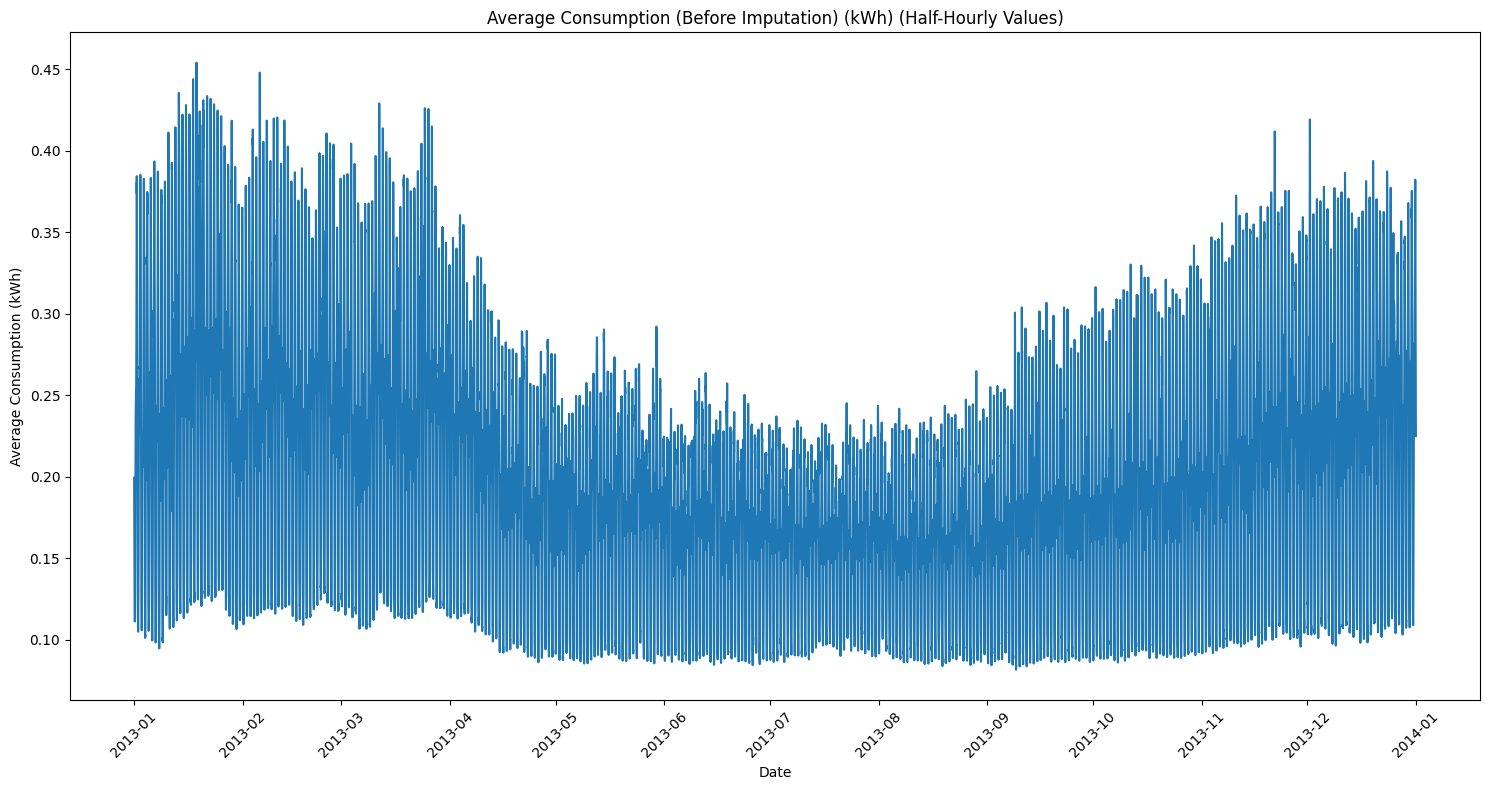

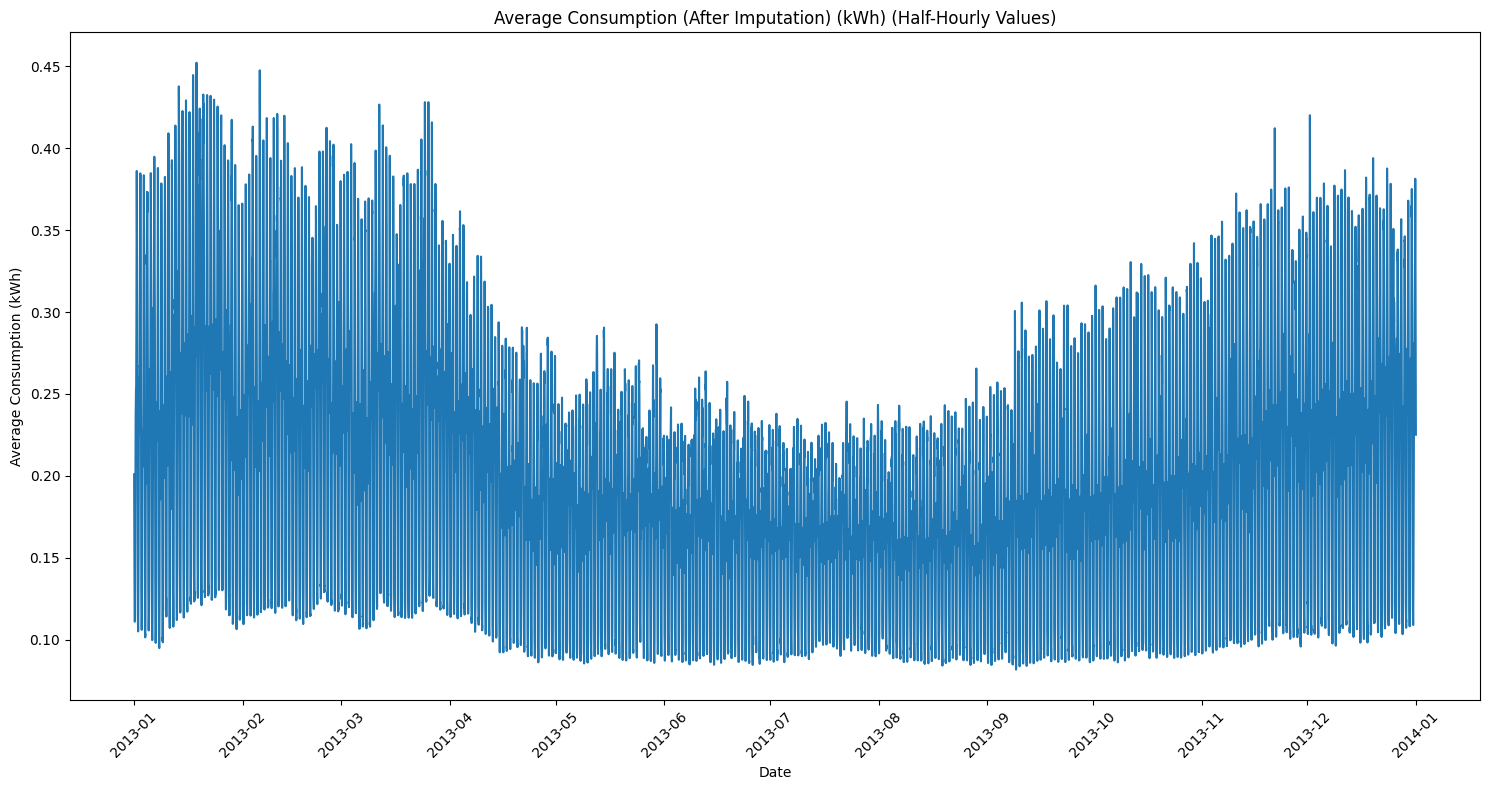

Missing values in consumption_imputed after imputation:
GMT             0
household_id    0
consumption     0
dtype: int64


In [8]:
# Functions to plot the average consumption before and after imputation
def calculate_avg_consumption(df):
    avg_consumption = df.groupby('GMT')['consumption'].mean().reset_index()
    return avg_consumption

def plot_avg_consumption(avg_consumption, title):
    plt.figure(figsize=(15, 8))
    plt.plot(avg_consumption['GMT'], avg_consumption['consumption'])
    plt.title(title + ' (Half-Hourly Values)')
    plt.xlabel('Date')
    plt.ylabel('Average Consumption (kWh)')
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Pre-Imputation Analysis
avg_consumption_before = calculate_avg_consumption(consumption_melted)
plot_avg_consumption(avg_consumption_before, 'Average Consumption (Before Imputation) (kWh)')

# Imputation
consumption_imputed = consumption_melted_filtered.copy()
consumption_imputed = consumption_imputed.set_index('GMT')
consumption_imputed['consumption'] = consumption_imputed.groupby('household_id')['consumption'].transform(lambda x: x.interpolate(method='time').ffill().bfill())
consumption_imputed = consumption_imputed.reset_index()

# Post-Imputation Analysis
avg_consumption_after = calculate_avg_consumption(consumption_imputed)
plot_avg_consumption(avg_consumption_after, 'Average Consumption (After Imputation) (kWh)')

# Check for missing values after imputation
missing_values_after_imputation = consumption_imputed.isnull().sum()
print("Missing values in consumption_imputed after imputation:")
print(missing_values_after_imputation)

### The plot before and after imputation look nearly identical, which is a good sign. Let's now aggregate the data to hourly granularity and merge the two datasets (tariff + consumption)

In [9]:
# Create 'hour' column for consumption and tariff data, shifting the time 30 minutes forward
consumption_imputed['hour'] = (consumption_imputed['GMT'] + pd.Timedelta(minutes=30)).dt.floor('H')
tariff_data_filtered['hour'] = (tariff_data_filtered['GMT'] + pd.Timedelta(minutes=30)).dt.floor('H')

# Aggregate consumption data to hourly
consumption_hourly = consumption_imputed.groupby(['hour', 'household_id'])['consumption'].sum().reset_index()

# Aggregate tariff data to hourly using average price
# Averaging should not be needed as the tariff does not change in half-hourly increments, but we will do it regardless
tariff_hourly = tariff_data_filtered.groupby('hour')['Price'].mean().reset_index()

# Merge datasets and rename columns for clarity
merged_data = pd.merge(consumption_hourly, tariff_hourly, on='hour', how='left')
merged_data.rename(columns={'hour': 'timestamp', 'Price': 'tariff'}, inplace=True)

# Sort the dataframe by timestamp and then by household_id
merged_data.sort_values(by=['timestamp', 'household_id'], inplace=True)

# Set the timestamp as the index
merged_data.set_index('timestamp', inplace=True)

# Save the new dataframe to a CSV file
merged_data.to_csv('1a) consumption_and_tariff_data_hourly.csv')

In [10]:
# Print some information about the dataset
print(merged_data.head())
print("\nUnique tariff values:")
print(merged_data['tariff'].unique())

# We should have 24 * 365 * 1007, or 8821320 rows in the dataset)
print("\nShape of the data:")
print(merged_data.shape)

print("\nColumns in the final dataset:")
print(merged_data.columns)
print("\nMissing values:")
print(merged_data.isnull().sum())

# Print # of unique household id values
print("\nNumber of Unique household ID values:")
print(merged_data['household_id'].nunique())

                    household_id  consumption  tariff
timestamp                                            
2013-01-01 01:00:00        D0000        0.589  0.1176
2013-01-01 01:00:00        D0001        0.454  0.1176
2013-01-01 01:00:00        D0002        0.458  0.1176
2013-01-01 01:00:00        D0003        0.154  0.1176
2013-01-01 01:00:00        D0004        0.390  0.1176

Unique tariff values:
[0.1176 0.0399 0.672 ]

Shape of the data:
(8821320, 3)

Columns in the final dataset:
Index(['household_id', 'consumption', 'tariff'], dtype='object')

Missing values:
household_id    0
consumption     0
tariff          0
dtype: int64

Number of Unique household ID values:
1007


### Load and Process Weather Data

In [11]:
# Get all the weather CSV files
csv_files = glob.glob('London,UK*.csv')

def read_csv_with_datetime_index(file):
    df = pd.read_csv(file)
    df['datetime'] = pd.to_datetime(df['datetime']) 
    df.set_index('datetime', inplace=True)
    return df

# Read and concatenate all CSV files
df_list = [read_csv_with_datetime_index(file) for file in csv_files]
merged_df = pd.concat(df_list)
merged_df.sort_index(inplace=True)

# Only keep important columns (informed by literature review)
merged_df = merged_df[['solarradiation', 'windspeed', 'temp', 'precip', 'humidity']]

### Deal with missing values, duplicated timestamps, and unusual entries

In [12]:
# Count missing values and also show them as a percentage 
missing_values = merged_df.isnull().sum()
missing_percentages = 100 * merged_df.isnull().sum() / len(merged_df)

print("Missing values and percentages:")
for column, count in missing_values.items():
    percentage = missing_percentages[column]
    print(f"{column}: {count} ({percentage:.2f}%)")

# Find duplicate timestamps
duplicate_timestamps = merged_df[merged_df.index.duplicated(keep=False)]

print("\nDuplicate timestamps before removal:")
print(duplicate_timestamps)

Missing values and percentages:
solarradiation: 0 (0.00%)
windspeed: 0 (0.00%)
temp: 0 (0.00%)
precip: 0 (0.00%)
humidity: 0 (0.00%)

Duplicate timestamps before removal:
                     solarradiation  windspeed  temp  precip  humidity
datetime                                                              
2013-10-27 01:00:00             0.0       26.6  13.8   0.016     92.49
2013-10-27 01:00:00             0.0       20.8  13.0   0.000     90.88


In [13]:
# Remove rows with duplicate timestamps, keeping only the first occurrence
merged_df = merged_df[~merged_df.index.duplicated(keep='first')]

# Check for duplicate timestamps after removal
duplicate_timestamps_after = merged_df[merged_df.index.duplicated(keep=False)]

print("\nDuplicate timestamps after removal:")
print(duplicate_timestamps_after)


Duplicate timestamps after removal:
Empty DataFrame
Columns: [solarradiation, windspeed, temp, precip, humidity]
Index: []


In [14]:
# Find unusual entries with non-hourly granularity
time_diffs = merged_df.index.to_series().diff().dropna()
unusual_entries = time_diffs[time_diffs != pd.Timedelta(hours=1)]

print("\nUnusual entries with non-hourly granularity:")
for timestamp, time_diff in unusual_entries.items():
    print(f"Timestamp: {timestamp}, Time Difference: {time_diff}")

# Find unusual entries with non-hourly granularity
time_diffs = merged_df.index.to_series().diff().dropna()
unusual_entries = time_diffs[time_diffs != pd.Timedelta(hours=1)]

print("\nUnusual entries with non-hourly granularity:")
for timestamp, time_diff in unusual_entries.items():
    print(f"Timestamp: {timestamp}, Time Difference: {time_diff}")


Unusual entries with non-hourly granularity:
Timestamp: 2013-03-31 02:00:00, Time Difference: 0 days 02:00:00

Unusual entries with non-hourly granularity:
Timestamp: 2013-03-31 02:00:00, Time Difference: 0 days 02:00:00


### The assumption is that the unusual entry at 2013-03-31 02:00:00 is due to daylight savings time change. We will interpolate the missing hour by taking the average of the values before and after the missing hour.

In [15]:
for timestamp, time_diff in unusual_entries.items():
    if time_diff == pd.Timedelta(hours=2):
        prev_timestamp = timestamp - pd.Timedelta(hours=2)
        next_timestamp = timestamp
        interpolated_row = merged_df.loc[prev_timestamp].combine(merged_df.loc[next_timestamp], lambda x, y: (float(x) + float(y)) / 2)
        interpolated_timestamp = prev_timestamp + pd.Timedelta(hours=1)
        merged_df.loc[interpolated_timestamp] = interpolated_row
        print(f"Interpolated missing hour at: {interpolated_timestamp}")

# Sort the DataFrame again to ensure the interpolated row is in the correct position
merged_df.sort_index(inplace=True)

# Check for unusual entries with non-hourly granularity again after interpolation
time_diffs_after_interpolation = merged_df.index.to_series().diff().dropna()
unusual_entries_after_interpolation = time_diffs_after_interpolation[time_diffs_after_interpolation != pd.Timedelta(hours=1)]

print("\nUnusual entries with non-hourly granularity after interpolation:")
for timestamp, time_diff in unusual_entries_after_interpolation.items():
    print(f"Timestamp: {timestamp}, Time Difference: {time_diff}")

# Save the merged DataFrame
merged_df.to_csv('1b) merged_weather_data.csv')

Interpolated missing hour at: 2013-03-31 01:00:00

Unusual entries with non-hourly granularity after interpolation:
